In [1]:
import matplotlib.pyplot as plt
from scipy.stats import describe
import numpy as np
import pandas as pd
import operator
from astropy.table import QTable, Table, Column
from astropy import units as u

                                                      PROBLEMA DE RUINA


$$X_{t}= x_0 +ct - \sum_{i=1} ^ {N_t} Zi$$
             
Donde $Z_i$ se distribuye exponencial.

Probar la condición de ganancia neta $$c>\frac{(\mu_{1_H} \rho + a \delta)}{(\delta-\mu_{1G})}\mu_{1_Z}$$
donde $x_0$ es constante y $c$ es constante

Se realizará la simulación propuesta por Dassios y Zhao para calcular los tiempos de saltos del modelo.

In [2]:
def simulation2(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.uniform(0,1)))
    d1=1+((delta*np.log(np.random.uniform(0,1)))/lambda0-a)
    lambdat=[]
    Ti=[]
    size=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.uniform(0,1)))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.uniform(0,1)))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=np.random.exponential(scale=1/beta)
        lambdat.append(lambdamenos+SJ)
        size.append(SJ)
        N=1
    else:
        EJ=np.random.exponential(scale=1/alpha)
        lambdat.append(lambdamenos+EJ)
        size.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.uniform(0,1)))
        d1=1+((delta*np.log(np.random.uniform(0,1)))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.uniform(0,1)))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.uniform(0,1)))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        lambdamenos=a+(lambdat[i-1]-a)*np.exp(-delta*(Ti[i]-Ti[i-1]))
        if S<E:
            SJ=np.random.exponential(scale=1/beta)
            lambdat.append(lambdamenos+SJ)
            size.append(SJ)
            N=1+N
        else:
            EJ=np.random.exponential(scale=1/alpha)
            lambdat.append(lambdamenos+EJ)
            size.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,size

$\quad$

Los parámetros a utilizar durante la primera simulación serán:
$$(a,\rho,\delta,\alpha,\beta,\gamma,\lambda_0,T,c,x_0)=(0.7,0.5,2.0,2.0,1.5,1.0,0.7,50,1.5,10) $$

$\quad$

In [4]:
a=0.7;rho=0.5;delta=2.0;alpha=2.0;beta=1.5;gamma=1.0;lambda0=0.7;T=50;c=1.5;x_0=10

In [5]:
Ti,Nt,N,lambdat,size=simulation2(a,rho,delta,alpha,beta,lambda0,T)

In [6]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        intr=Nt[0]
        
    else:
        intr=Nt[i]-Nt[i-1]
    Nt_final.append(intr)    
    i=i+1
    if i ==10000000:
        break

In [7]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

                                                     GRÁFICAS

La gráfica del proceso puntual respecto a el tiempo nos permitirá conocer los tiempos en los cuales ocurrren saltos internos y en cuales se mantiene constante teniendo saltos externos en algún instante $T_i$

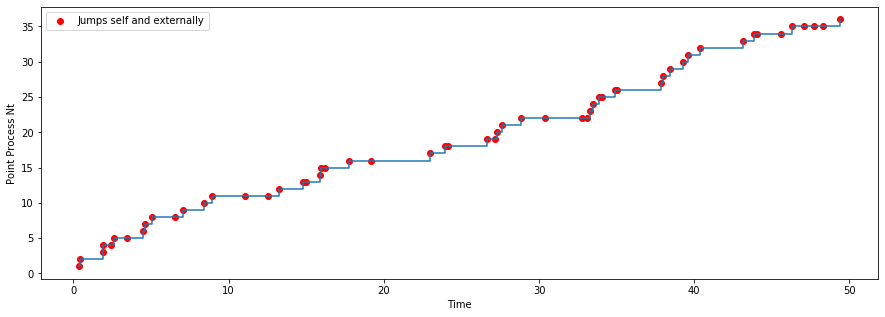

In [8]:
plt.figure(figsize=(15,5))
plt.scatter(Ti,Nt,label='Jumps self and externally',color='red')
plt.step(Ti,Nt,where='post')
#plt.title('Ti vs Nt')
plt.xlabel('Time')
plt.ylabel('Point Process Nt')
plt.legend()
#plt.savefig("Proceso_Conteo.jpg", bbox_inches='tight')

Siguiendo la simulación para el proceso de intensidad $\lambda_t$ podemos obtener los tiempos en los cuales ocurren saltos junto con su respectiva intesidad para ese instante de tiempo  

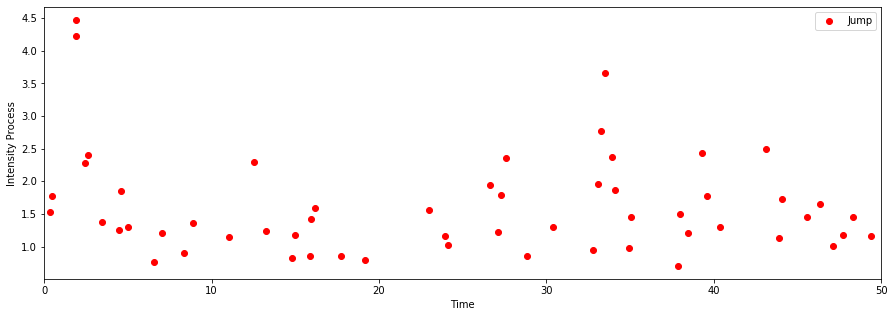

In [9]:
plt.figure(figsize=(15,5))
plt.xlim(0,T)
plt.scatter(Ti,lambdat,label='Jump',color='red')
plt.xlabel('Time')
plt.ylabel('Intensity Process')
plt.legend()
#plt.savefig("Proceso_Intensidad.jpg", bbox_inches='tight')

Se realizará una modificación al algoritmo de simulación de tal manera que se puedan conocer la diferencia entre la ocurrencia de un salto interno y uno externo. Esto nos servirá para calcular la media de cada uno de ellos y poder realizar el cálculo de la condición de ganancia neta.

In [11]:
def simulation3(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.uniform(0,1)))
    d1=1+((delta*np.log(np.random.uniform(0,1)))/lambda0-a)
    lambdat=[]
    Ti=[]
    size=[]
    sizeSJ=[]
    sizeEJ=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.uniform(0,1)))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.uniform(0,1)))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=np.random.exponential(scale=1/beta)
        lambdat.append(lambdamenos+SJ)
        size.append(SJ)
        sizeSJ.append(SJ)
        N=1
    else:
        EJ=np.random.exponential(scale=1/alpha)
        lambdat.append(lambdamenos+EJ)
        size.append(EJ)
        sizeEJ.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.uniform(0,1)))
        d1=1+((delta*np.log(np.random.uniform(0,1)))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.uniform(0,1)))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.uniform(0,1)))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        
        if S<E:
            SJ=np.random.exponential(scale=1/beta)
            lambdat.append(lambdamenos+SJ)
            size.append(SJ)
            sizeSJ.append(SJ)
            N=1+N
        else:
            EJ=np.random.exponential(scale=1/alpha)
            lambdat.append(lambdamenos+EJ)
            size.append(EJ)
            sizeEJ.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,sizeSJ,sizeEJ

Se realizará la simulación con los parámetros $$(a,\rho,\delta,\alpha,\beta,\gamma,\lambda_0,c,X_0,T)=(0.7,0.5,2.0,2.0,1.5,1.0,0.7,1.5,10,50) $$

In [12]:
a=0.7;rho=0.5;delta=2.0;alpha=2.0;beta=1.5;gamma=1.0;lambda0=0.7;c=1.5;x_0=10;T=50

In [37]:
Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)

$\quad$

Cálculo de las esperanzas de los saltos internos y externos para determinar la condición de ganancia neta.

In [38]:
mu1G=describe(sizeSJ).mean
mu1H=describe(sizeEJ).mean
print((mu1G,mu1H))
print(np.max(Nt))

(0.7960059599825331, 0.5025501101238325)
46


$\quad$

La gráfica del número de saltos internos para la nueva simulación incluirá el valor esperado del proceso puntual dada la condición estacionaria.

$\quad$

46 68.57488493206995


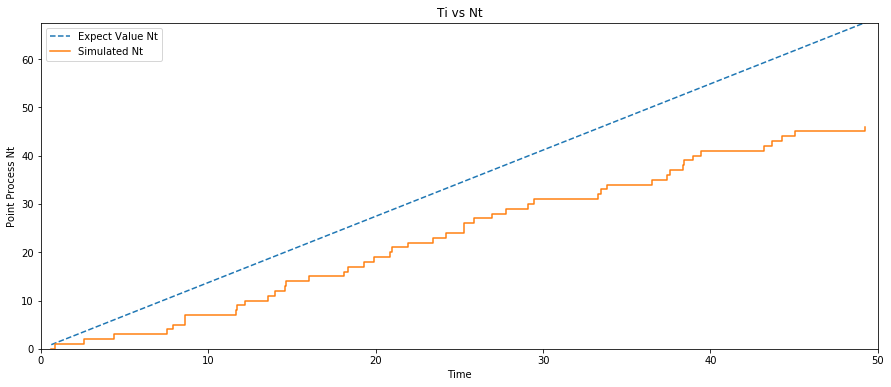

In [39]:
E_Nt=(mu1H * rho + a * delta)*T/(delta- mu1G)
E_Nt1=[]
i=0
while i<len(Ti):
    
    E_Nt2=(mu1H * rho + a * delta)*Ti[i]/(delta- mu1G)
    E_Nt1.append(E_Nt2)
    i=i+1
    if i==10000000:
        break
    

    
plt.figure(figsize=(15,6))
plt.plot(Ti,E_Nt1,linestyle='--',label='Expect Value Nt')
plt.step(Ti,Nt,where='post', label='Simulated Nt')
plt.title('Ti vs Nt')
plt.xlim(0,T)
plt.ylim(0,np.max(E_Nt1))
plt.xlabel('Time')
plt.ylabel('Point Process Nt')
plt.legend()
print(np.max(Nt),E_Nt)

$\quad$

Se realiza la simulación del tamaño de las reclamaciones que siguen distribución exponencial. Únicamente se tienen en cuenta los saltos internos para su cálculo.

$\quad$

In [40]:
z=[]
i=0
while i<len(Nt):
    y=np.random.exponential(scale=1/gamma)
    z.append(y)
    i=i+1
    if i==200000:
        break
mu1G=describe(sizeSJ).mean
mu1H=describe(sizeEJ).mean
mu1Z=describe(z).mean

$\quad$

Se comprueba que se cumpla la condición de ganancia neta para la prima $c$ dada en los parámetros iniciales

$\quad$

In [41]:
net=((mu1H* rho + a * delta)*mu1Z)/(delta-mu1G)
if c>net:
    print('Satisfy the Net Profit Condition')
else:
    print('Does not satisfy the Net Profit Condition')



Satisfy the Net Profit Condition


In [42]:
#Tamaño de la reclamación y número de reclamaciones
print(np.size(z),z)

77 [0.3409468665476979, 1.9318818025610338, 0.8193844525033654, 1.0130340554381192, 1.5499224570759462, 3.203417999300095, 2.514639414422569, 2.645267273005975, 0.2914840193161915, 0.6541271955657585, 2.558121211242732, 1.8714995782462398, 2.3707213365366444, 1.4238620925028198, 2.1845059145480703, 1.8522937011746492, 0.9134056709767275, 2.201342499495099, 0.7919658597744982, 1.768486049194291, 0.4377496980291389, 1.7017772471365076, 1.2155729723690503, 2.6131768937773696, 0.030640729294867507, 0.3323899718542702, 0.6431174263577382, 0.7069208536853131, 3.765792595642913, 0.7096552343295515, 0.09764264694051801, 1.3651502896300856, 1.0576199638690589, 0.2621803409719641, 0.3237764942445363, 0.21589806789641294, 0.027798184770948812, 0.9190565305424274, 0.6837553174663594, 2.5201144990808464, 0.12083089596946489, 2.4827128820222026, 1.806278463332503, 0.3286232024823868, 0.4173092538455, 0.7359816691469252, 0.2810194865254932, 0.9621137216885192, 0.40912385767514653, 0.37555919586165365

In [43]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        hola=Nt[0]
        
    else:
        hola=Nt[i]-Nt[i-1]
    Nt_final.append(hola)    
    i=i+1
    if i ==10000000:
        break

In [44]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

In [45]:
#Tamaño de los saltos internos
z_S = list(map(operator.mul, z, Nt_final))

In [46]:
X_t=[]
i=0
while i<len(Ti):
    xt=x_0+c*(Ti[i])-np.cumsum(z_S)[i]
    X_t.append(xt)
    i=i+1
    if i==2000000:
        break

In [47]:
X_t

[10.937221573697572,
 11.20186942488777,
 10.478922849443217,
 11.274788800767821,
 11.971669782836125,
 9.845205967991085,
 10.00672533818145,
 12.15334413166064,
 12.503452925824329,
 11.994974150378255,
 10.547508725603215,
 8.688802722251232,
 8.71898117378721,
 11.805513724878555,
 9.731324036294875,
 9.799672777380838,
 9.482129895769003,
 10.82970838196589,
 10.753278825650913,
 11.357721514597372,
 10.927547959172973,
 10.151599987336446,
 9.040488254695653,
 8.45901503908194,
 9.69067925958231,
 10.646811995517389,
 10.947733518038508,
 10.630922994815265,
 8.333917679467532,
 8.47127817626491,
 9.059879263831206,
 8.536347445988483,
 7.64200683034877,
 8.862381766445388,
 10.752147492524713,
 11.075531102372508,
 11.939673110019612,
 12.310274709911077,
 12.789407344600477,
 10.345085610214952,
 11.09305630196161,
 10.223063795087391,
 10.719527701281521,
 11.116254452077861,
 11.433683382960531,
 12.400534120160124,
 12.559677750847165,
 11.940877408202859,
 14.0147588076927

$\quad$

Dada la prima $c$, se procede a calcular el superávit de la compañía para la ventana de tiempo $t$.



$\quad$

In [48]:
i=0
h=0
X_t_2=X_t
Ti_2=Ti
while i < len(z_S):
    if z_S[i]!=0:
        
        X_t_a=X_t_2[:i+h]
        X_t_a.append(z_S[i]+X_t[i])
        X_t_b=X_t_2[i+h:]
        X_t_2=X_t_a+X_t_b
        
        Ti_a=Ti_2[:i+h]
        Ti_a.append(Ti[i])
        Ti_b=Ti_2[i+h:]
        Ti_2=Ti_a+Ti_b
        h+=1
    i+=1

Text(0, 0.5, 'Surplus Xt')

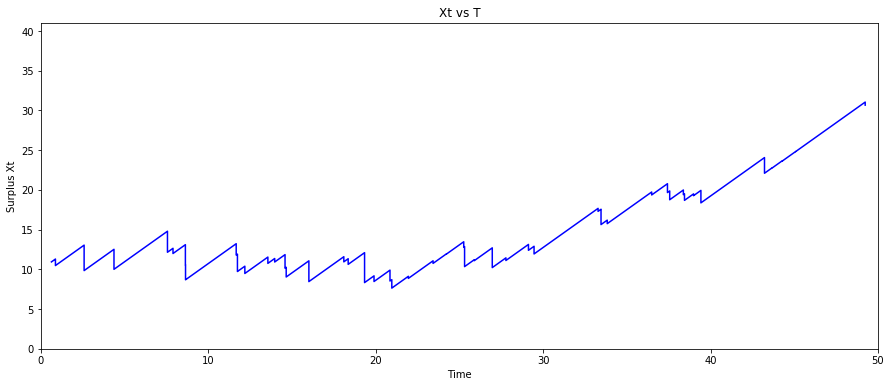

In [49]:
plt.figure(figsize=(15,6))
plt.plot(Ti_2,X_t_2,color='blue')
plt.title('Xt vs T')
plt.xlim(0,T)
plt.ylim(0,np.max(X_t_2)+10)
plt.xlabel('Time')
plt.ylabel('Surplus Xt')

$\quad$

Se definirá la función de ruina para el superávit dado con el fin de conocer la probabilidad de ruina de la compañía en un intervalo de tiempo dado

$\quad$

In [50]:
def ruina3(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim):
    
    x_t=[]
    z1=[]
    initial=0
    i=0
    while initial<sim:
        Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)
        z1=np.random.exponential(scale=1/gamma,size=np.max(Nt))
        x=x_0+c*T-np.sum(z1)
        x_t.append(x)
        initial=initial+1
        if initial==100000:
            break
    return x_t,z1

In [51]:
sim=100
x_t,z1=ruina3(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim)

In [52]:
x_t

[48.54220585412214,
 40.02494525406728,
 48.71314507625581,
 49.979930050979156,
 48.99130006064936,
 46.77070392722848,
 53.03690274264257,
 46.213472336309586,
 46.73126200959471,
 53.32122715332773,
 33.96749137569204,
 57.11557955005045,
 46.48706440822811,
 45.24459897411697,
 39.35374634379491,
 46.11659524821244,
 51.72479983341374,
 57.92547045316478,
 47.75809124909323,
 60.38689900936235,
 43.959037646556084,
 60.61819705560431,
 45.628291441221286,
 45.72131363611807,
 46.68796641679022,
 46.1050998938934,
 48.299212818777974,
 47.65873324422032,
 47.19040196912881,
 50.93042448483369,
 52.8988785905424,
 49.20192459987487,
 60.097601822133115,
 48.38489535255991,
 41.264294623019914,
 42.35694507306549,
 40.4358287021993,
 41.77092768551964,
 35.50787571510117,
 46.142283969998836,
 55.80271693359116,
 45.797435822555244,
 39.918422558938296,
 50.556483819285916,
 29.422674021233313,
 52.42684157401602,
 40.195133416423744,
 43.926148656077665,
 44.221981851915196,
 57.4848

Primera simulación de la probabilidad de ruina de la compañía. 

In [53]:
i=0
count=0
while i < len(x_t):
    if x_t[i]<0:
        count=count+1
    i=i+1
    if i==200000:
        break

P_ruina=(count/len(x_t))        
P_ruina

0.0

$\quad$

Se realiza la simulación de la probabilidad de ruina para un tiempo lo "suficientemente" grande para conocer la convergencia de la probabilidad. Siguiendo el tiempo dado por Dassios y Zhao, se realizará por intervalos de 5 unidades hasta un tiempo de 400.
La observación adicional se obtendrá cambiando el valor de la prima, ya que si la condición de ganancia neta se cumple, la probabilidad de ruina será cero para todos los intervalos de tiempo. 

$\quad$

In [55]:
c=0.8
sim=100
P_ruina1=[]

for T in range(0,800,5):
    x_t,z1=ruina3(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim)
    #i=0
    #count=0
    ixs=np.array(x_t) <=0
    count=sum(ixs)
    
    #while i < len(x_t):
     #   if x_t[i]<0:
      #      count=count+1
       # i=i+1
        #if i==200000:
         #   break

    P_ruina=(count/len(x_t))        
    P_ruina1.append(P_ruina)
        
P_ruina1

[0.0,
 0.0,
 0.02,
 0.01,
 0.03,
 0.05,
 0.07,
 0.06,
 0.09,
 0.06,
 0.07,
 0.04,
 0.13,
 0.16,
 0.13,
 0.08,
 0.07,
 0.13,
 0.16,
 0.11,
 0.15,
 0.1,
 0.15,
 0.25,
 0.15,
 0.13,
 0.16,
 0.13,
 0.11,
 0.14,
 0.1,
 0.17,
 0.19,
 0.24,
 0.12,
 0.17,
 0.2,
 0.2,
 0.15,
 0.14,
 0.19,
 0.17,
 0.16,
 0.14,
 0.12,
 0.15,
 0.23,
 0.26,
 0.2,
 0.23,
 0.17,
 0.17,
 0.12,
 0.14,
 0.22,
 0.23,
 0.24,
 0.18,
 0.14,
 0.18,
 0.21,
 0.26,
 0.18,
 0.23,
 0.17,
 0.21,
 0.18,
 0.1,
 0.22,
 0.17,
 0.16,
 0.16,
 0.21,
 0.12,
 0.21,
 0.22,
 0.17,
 0.11,
 0.15,
 0.18,
 0.24,
 0.2,
 0.19,
 0.18,
 0.17,
 0.21,
 0.12,
 0.21,
 0.18,
 0.12,
 0.14,
 0.14,
 0.18,
 0.18,
 0.14,
 0.22,
 0.19,
 0.14,
 0.17,
 0.21,
 0.13,
 0.15,
 0.17,
 0.1,
 0.21,
 0.14,
 0.15,
 0.18,
 0.17,
 0.12,
 0.15,
 0.2,
 0.16,
 0.19,
 0.13,
 0.22,
 0.21,
 0.19,
 0.11,
 0.13,
 0.13,
 0.19,
 0.11,
 0.14,
 0.15,
 0.16,
 0.11,
 0.17,
 0.17,
 0.16,
 0.09,
 0.2,
 0.14,
 0.13,
 0.22,
 0.2,
 0.18,
 0.2,
 0.08,
 0.11,
 0.17,
 0.16,
 0.16,
 0.15,
 0.12,

In [ ]:
plt.figure(figsize=(15,6))
plt.scatter(np.linspace(0,800,160),P_ruina1)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.ylim(0,np.max(P_ruina1)+0.1)
#plt.savefig("ruina_probability.jpg", bbox_inches='tight')

In [ ]:
np.max(P_ruina1)